In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from datetime import timedelta, datetime as dt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt

In [ ]:
df = pd.read_csv('saas.csv')

In [ ]:
df.head()

In [ ]:
df.Amount.value_counts()

In [ ]:
df.Subscription_Type.value_counts()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.shape

# 1.Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [2]:
# Have to use parenthesis in order to comment each line
def prep_data(df):
    return(df.assign(m_invoice = pd.to_datetime(df.Month_Invoiced)). # assigned m_invoice as the new varible 
    # to have date time assigned
    sort_values('m_invoice'). # Sorting values by the m_invoice
    reset_index().set_index('m_invoice') # index set to m_invoice
    [['Amount']]. # Selecting only the amount column to sum
    resample('M').sum()) # Resampling by month and summing

In [ ]:
df = prep_data(df)

In [ ]:
df.head()

In [ ]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [ ]:
print(len(train) + len(validate) + len(test) == len(df))

In [ ]:
print(df.head(1) == train.head(1))

In [ ]:
# validating the train validate split
pd.concat([train.tail(1), validate.head(1)])

In [ ]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

# 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.


In [3]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [4]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [5]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Forecast
**Last observed value**
The simplest method for forecasting is to predict all future values to be the last observed value.

Make Predictions

In [ ]:
train.tail(5)

In [ ]:
amount = train['Amount'][-1:][0]
print(amount)

In [ ]:
yhat_df = pd.DataFrame({'Amount': [amount]}, index = validate.index)

In [ ]:
yhat_df.head()

In [ ]:
for col in train.columns:
    plot_and_eval(col)

## Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)
eval_df

# Simple Average
Take the simple average of historical values and use that value to predict future values.

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

**Make Predictions**

In [ ]:
amount = round(train['Amount'].mean(),2)
amount

In [6]:
def make_predictions():
    yhat_df = pd.DataFrame({'Amount': [amount]}, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

NameError: name 'amount' is not defined

In [ ]:
yhat_df.head()

In [ ]:
for col in train.columns:
    plot_and_eval(col)

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

# Moving Average
In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

**Make Predictions**

In [ ]:
# Since the data is in monthlt increments, computing a 30 day rolling average or every other month
# use the most recent/last 30 day period value to predict forward. 

period = 2

amount = train['Amount'].rolling(period).mean()[-1]
yhat_df = make_predictions()
yhat_df.head(3)

### Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using Moving Average

In [ ]:
for col in train.columns:
    plot_and_eval(col)

### Evaluate
Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [ ]:
periods = [2, 4, 6]

for p in periods:

    amount = train['Amount'].rolling(p).mean()[-1]
    #Uses amount from above to validate
    yhat_df = make_predictions()
    model_type = str(p) + 'M moving average'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                 target_var = col
                                )

In [ ]:
eval_df

# Holt's Linear Trend
Exponential smoothing applied to both the average and the trend (slope).
- α / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
- β / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. Seasonal Decomposition

First, let's take a look at the seasonal decomposition for each target.

In [ ]:
for col in train.columns:
    print(col,'\n') # new line
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

### Make Predictions

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

Holt:

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit:

- smoothing_level (α): value between (0,1)
- smoothing_slope (β): value between (0,1)

In [ ]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized = True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items,2)

In [ ]:
yhat_df.head()

In [ ]:
for col in train.columns:
    plot_and_eval(target_var = col)

### Evaluate

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized',
                            target_var = col)

In [ ]:
eval_df.sort_values(by='rmse')

# Predict Based on Previous Cycle
Going to use 7 months for train and 3 months for validate and test

In [ ]:
df = pd.read_csv('saas.csv')

In [ ]:
df.head()

In [ ]:
# Have to use parenthesis in order to comment each line
def prep_data(df):
    return(df.assign(m_invoice = pd.to_datetime(df.Month_Invoiced)). # assigned m_invoice as the new varible 
    # to have date time assigned
    sort_values('m_invoice'). # Sorting values by the m_invoice
    reset_index().set_index('m_invoice') # index set to m_invoice
    [['Amount']]. # Selecting only the amount column to sum
    resample('W').sum()) # Resampling by week and summing

In [ ]:
df = prep_data(df)
df.head()

In [ ]:
train.head()

# Stocks data set

In [7]:
from vega_datasets import data
df = data.stocks()
# to transform such that each symbol is it's own column and each row is one month
df = df.pivot_table('price', 'date', 'symbol')

In [8]:
df.head()

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2000-01-01,25.94,64.56,NaN,100.52,39.81
2000-02-01,28.66,68.87,NaN,92.11,36.35
2000-03-01,33.95,67.00,NaN,106.11,43.22
2000-04-01,31.01,55.19,NaN,99.95,28.37
2000-05-01,21.00,48.31,NaN,96.31,25.45


In [9]:
df.isnull().sum()

symbol
AAPL     0
AMZN     0
GOOG    55
IBM      0
MSFT     0
dtype: int64

In [10]:
df.describe()

symbol,AAPL,AMZN,GOOG,IBM,MSFT
count,123.000000,123.000000,68.000000,123.000000,123.000000
mean,64.730488,47.987073,415.870441,91.261220,24.736748
std,63.123782,28.891321,135.069851,16.513365,4.303958
min,7.070000,5.970000,102.370000,53.010000,15.810000
25%,11.155000,29.405000,338.395000,77.365000,21.760000
50%,36.810000,41.500000,420.460000,88.700000,24.110000
75%,102.460000,65.895000,503.625000,101.945000,27.295000
max,223.020000,135.910000,707.000000,130.320000,43.220000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2000-01-01 to 2010-03-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    123 non-null    float64
 1   AMZN    123 non-null    float64
 2   GOOG    68 non-null     float64
 3   IBM     123 non-null    float64
 4   MSFT    123 non-null    float64
dtypes: float64(5)
memory usage: 5.8 KB


In [12]:
df.shape

(123, 5)

In [13]:
# Setting a filter to df were google went public
df= df['2004-09-01':]

## Going to leave the data as is and not resample

In [14]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [15]:
train.shape, validate.shape, test.shape

((33, 5), (20, 5), (14, 5))

In [16]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [17]:
print(df.head(1) == train.head(1))

symbol      AAPL  AMZN  GOOG   IBM  MSFT
date                                    
2004-09-01  True  True  True  True  True


### Is the last row of train the day before the first row of validate? And the same for validate to test?

In [18]:
pd.concat([train.tail(1), validate.head(1)])

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2007-05-01,121.19,69.14,497.91,101.54,29.11
2007-06-01,122.04,68.41,522.70,100.25,27.95


In [19]:
pd.concat([validate.tail(1), test.head(1)])


symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2009-01-01,90.13,58.82,338.53,89.46,16.63
2009-02-01,89.31,64.79,337.99,90.32,15.81


### Plotting the data, viewing the data split

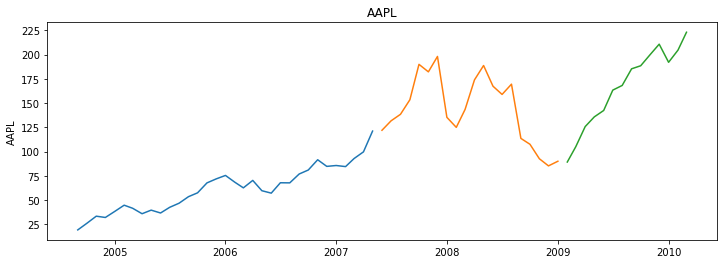

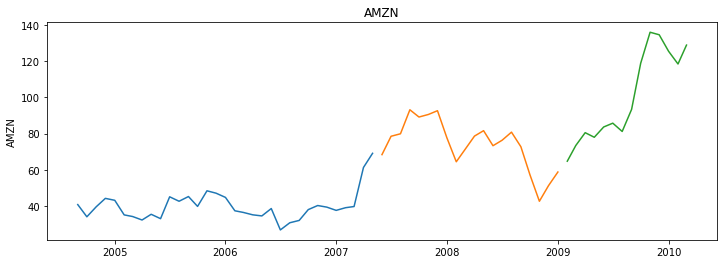

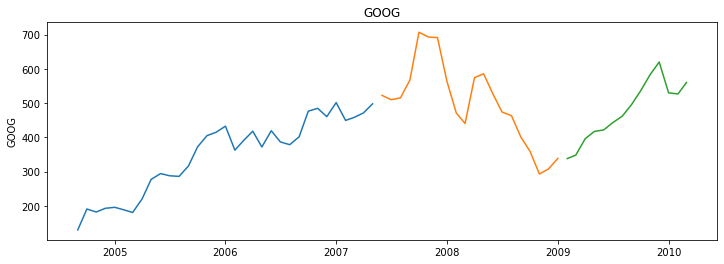

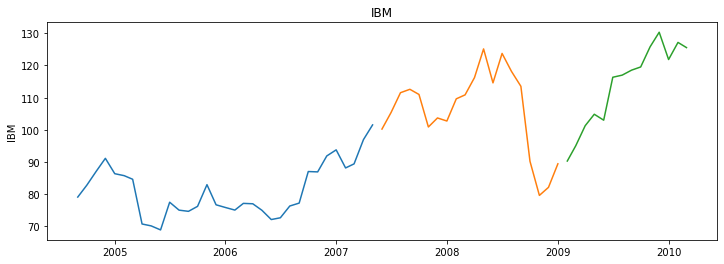

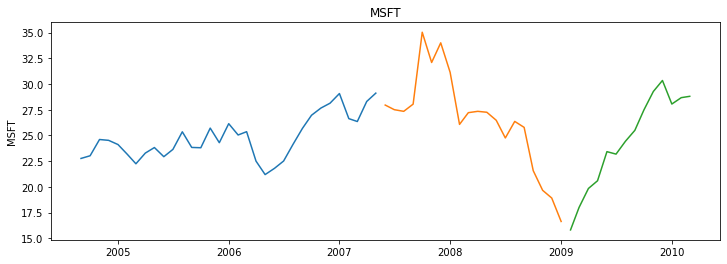

In [20]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


# Forecast
**Last observed value**
The simplest method for forecasting is to predict all future values to be the last observed value.

Make Predictions

In [21]:
# Last values to project foward
train.tail()

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2007-01-01,85.73,37.67,501.50,93.79,29.07
2007-02-01,84.61,39.14,449.45,88.18,26.63
2007-03-01,92.91,39.79,458.16,89.44,26.35
2007-04-01,99.80,61.33,471.38,96.98,28.30
2007-05-01,121.19,69.14,497.91,101.54,29.11


In [22]:
apple = train['AAPL'][-1:][0]
amazon = train['AMZN'][-1:][0]
google = train['GOOG'][-1:][0]
ibm = train['IBM'][-1:][0]
microsoft = train['MSFT'][-1:][0]

yhat_df = pd.DataFrame({'AAPL': [apple], 'AMZN': [amazon], 'GOOG': [google], 'IBM': [ibm], 'AMZN': [amazon], 'MSFT': [microsoft] }, 
                       index = validate.index)

yhat_df.head(2)

,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2007-06-01,121.19,69.14,497.91,101.54,29.11
2007-07-01,121.19,69.14,497.91,101.54,29.11


### Plotting Actual vs Predicted Values

AAPL -- RMSE: 41


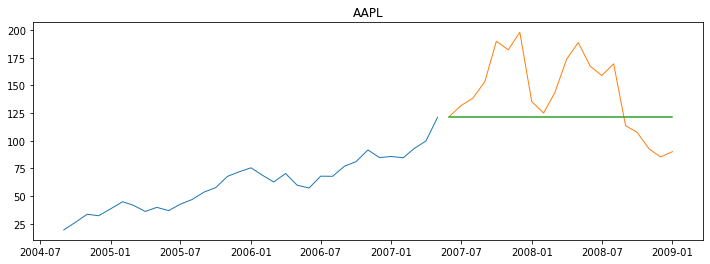

AMZN -- RMSE: 14


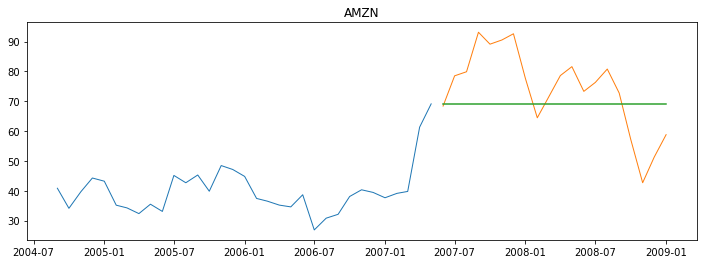

GOOG -- RMSE: 119


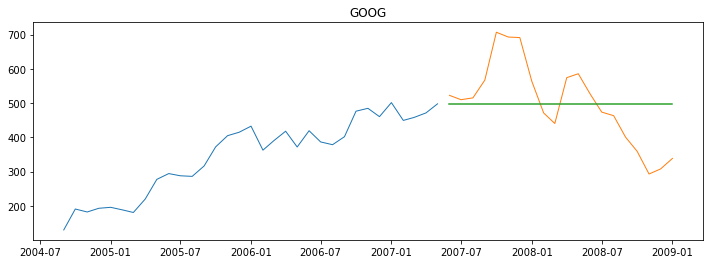

IBM -- RMSE: 13


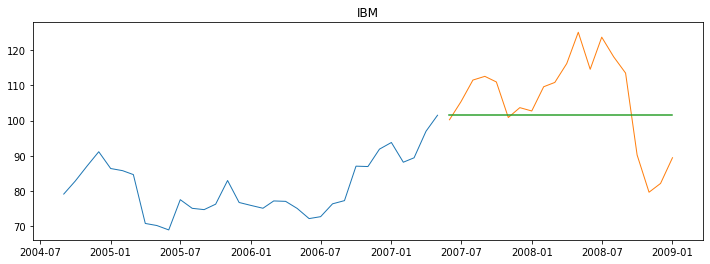

MSFT -- RMSE: 5


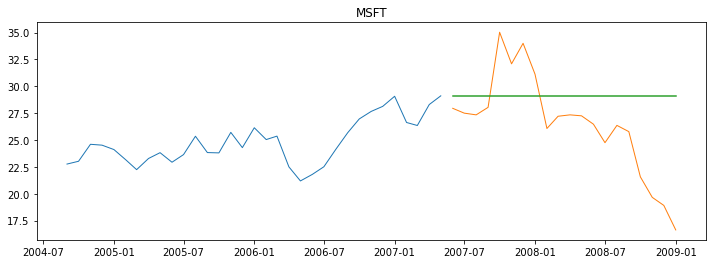

In [23]:
for col in train.columns:
    plot_and_eval(col)

In [24]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [25]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AAPL,41.0
1,last_observed_value,AMZN,14.0
2,last_observed_value,GOOG,119.0
3,last_observed_value,IBM,13.0
4,last_observed_value,MSFT,5.0


# Simple Average
### Make predictons

In [26]:
apple = train['AAPL'].mean()
amazon = train['AMZN'].mean()
google = train['GOOG'].mean()
ibm = train['IBM'].mean()
microsoft = train['MSFT'].mean()

def make_predictions():
    yhat_df = pd.DataFrame({'AAPL': [apple],
                           'AMZN': [amazon],
                           'GOOG': [google],
                           'IBM': [ibm],
                           'MSFT': [microsoft]
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [27]:
yhat_df.head()

,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2007-06-01,61.761515,40.1,348.307879,81.357273,24.776061
2007-07-01,61.761515,40.1,348.307879,81.357273,24.776061
2007-08-01,61.761515,40.1,348.307879,81.357273,24.776061
2007-09-01,61.761515,40.1,348.307879,81.357273,24.776061
2007-10-01,61.761515,40.1,348.307879,81.357273,24.776061


AAPL -- RMSE: 88


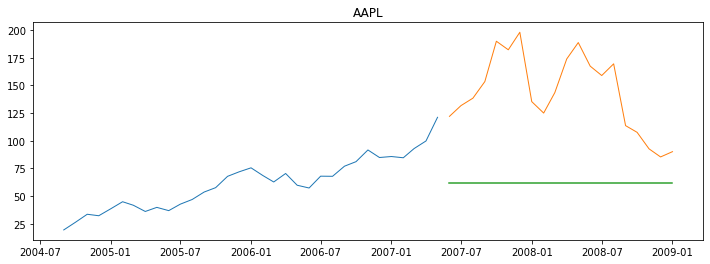

AMZN -- RMSE: 36


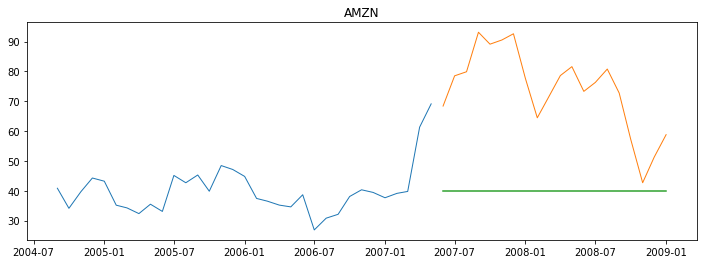

GOOG -- RMSE: 193


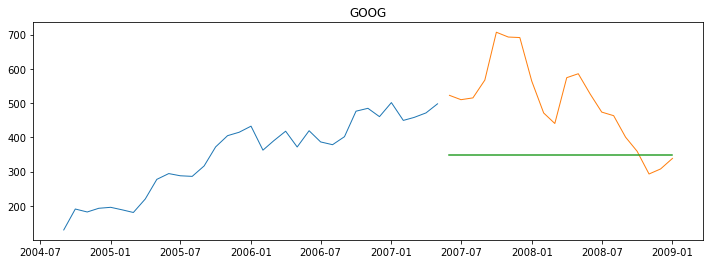

IBM -- RMSE: 28


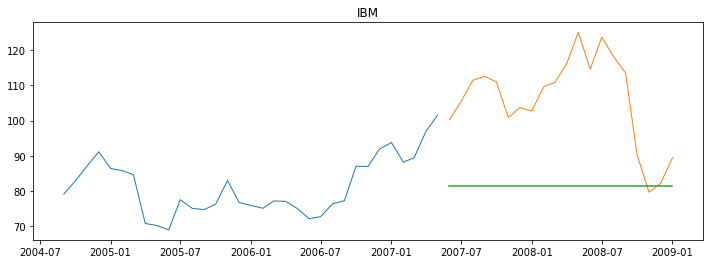

MSFT -- RMSE: 5


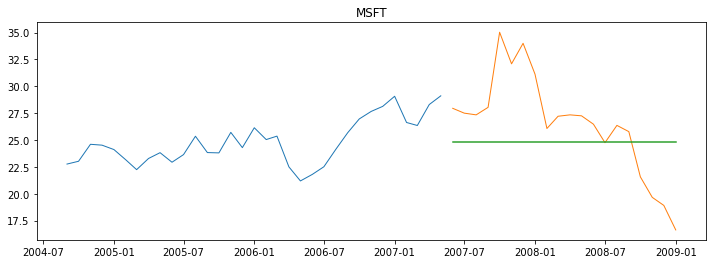

In [28]:
for col in train.columns:
    plot_and_eval(col)

In [29]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [30]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AAPL,41.0
1,last_observed_value,AMZN,14.0
2,last_observed_value,GOOG,119.0
3,last_observed_value,IBM,13.0
4,last_observed_value,MSFT,5.0
5,simple_average,AAPL,88.0
6,simple_average,AMZN,36.0
7,simple_average,GOOG,193.0
8,simple_average,IBM,28.0
9,simple_average,MSFT,5.0


# Moving Average
In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

### Make Predictions

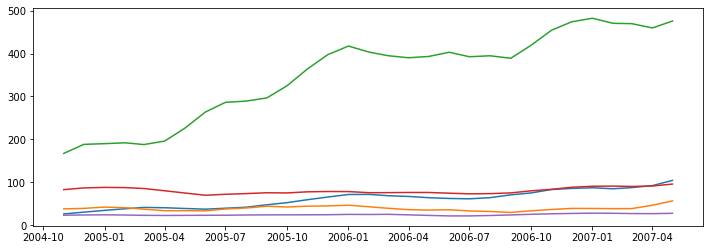

In [31]:
# Rolling by quarter
plt.figure(figsize=(12,4))
plt.plot(train['AAPL'].rolling(3).mean())
plt.plot(train['AMZN'].rolling(3).mean())
plt.plot(train['GOOG'].rolling(3).mean())
plt.plot(train['IBM'].rolling(3).mean())
plt.plot(train['MSFT'].rolling(3).mean())

In [32]:
# demonstrating that the mean of the first 3 months is equal to the rolling 3 months
print(train['AAPL'].head(3).mean())
print(train['AAPL'].rolling(3).mean()[2])

26.37
26.37


# Make Predicitons¶

In [33]:
period = 3
# Want just the last value use the index -1
apple = round(train['AAPL'].rolling(period).mean()[-1],2)
amazon = round(train['AMZN'].rolling(period).mean()[-1],2)
ibm = round(train['IBM'].rolling(period).mean()[-1],2)
google = round(train['GOOG'].rolling(period).mean()[-1],2)
microsoft = round(train['MSFT'].rolling(period).mean()[-1],2)

In [34]:
yhat_df = make_predictions()

In [35]:
yhat_df.head(2)

,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2007-06-01,104.63,56.75,475.82,95.99,27.92
2007-07-01,104.63,56.75,475.82,95.99,27.92


### Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using Moving Average

AAPL -- RMSE: 52


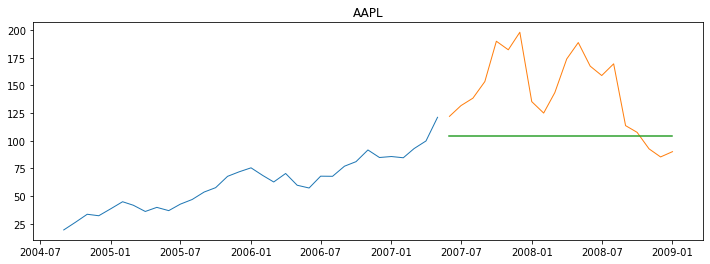

AMZN -- RMSE: 22


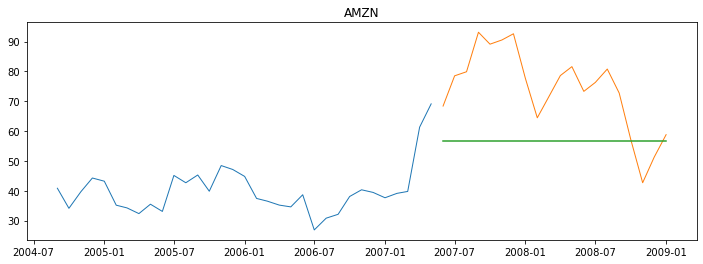

GOOG -- RMSE: 121


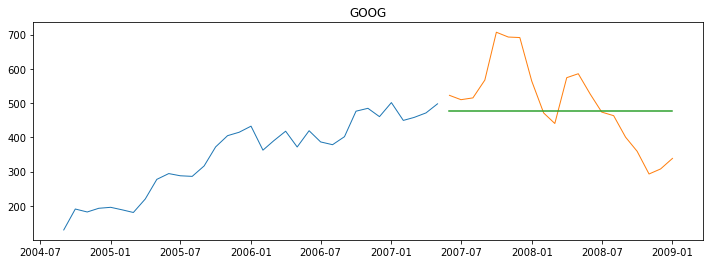

IBM -- RMSE: 16


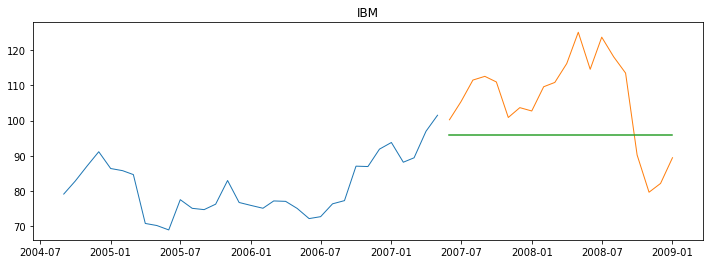

MSFT -- RMSE: 5


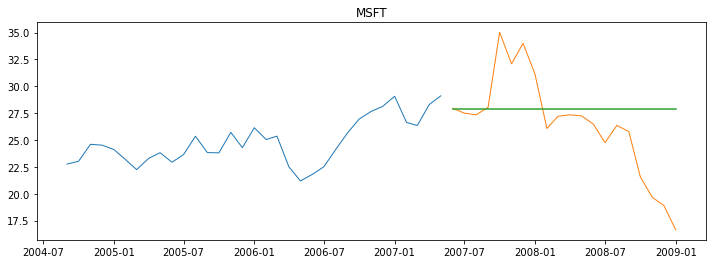

In [36]:
for col in train.columns:
    plot_and_eval(col)

# Evaluate
### Evaluate using MSE and RMSE, and add evaluation metrics to eval_df


In [37]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Quarterly moving average',
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,AAPL,41.0
1,last_observed_value,AMZN,14.0
2,last_observed_value,GOOG,119.0
3,last_observed_value,IBM,13.0
4,last_observed_value,MSFT,5.0
5,simple_average,AAPL,88.0
6,simple_average,AMZN,36.0
7,simple_average,GOOG,193.0
8,simple_average,IBM,28.0
9,simple_average,MSFT,5.0


In [69]:
# Set allows you to get unique values in the list
tickers = set(eval_df.target_var.tolist())

In [70]:
def min_rmse(tickers):
    min_list = []
    for x in tickers:
        min_list.append(eval_df[eval_df.target_var == x].min())
    return min_list

In [71]:
min_rmse(tickers)

[model_type    Quarterly moving average
 target_var                        MSFT
 rmse                                 5
 dtype: object,
 model_type    Quarterly moving average
 target_var                         IBM
 rmse                                13
 dtype: object,
 model_type    Quarterly moving average
 target_var                        GOOG
 rmse                               119
 dtype: object,
 model_type    Quarterly moving average
 target_var                        AMZN
 rmse                                14
 dtype: object,
 model_type    Quarterly moving average
 target_var                        AAPL
 rmse                                41
 dtype: object]

In [72]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AAPL,41.0
1,last_observed_value,AMZN,14.0
2,last_observed_value,GOOG,119.0
3,last_observed_value,IBM,13.0
4,last_observed_value,MSFT,5.0
5,simple_average,AAPL,88.0
6,simple_average,AMZN,36.0
7,simple_average,GOOG,193.0
8,simple_average,IBM,28.0
9,simple_average,MSFT,5.0


# Holt's Linear Trend
### Exponential smoothing applied to both the average and the trend (slope).
- α / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
- β / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. Seasonal Decomposition

First, let's take a look at the seasonal decomposition for each target.

AAPL 



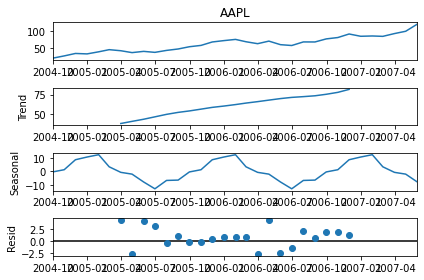

AMZN 



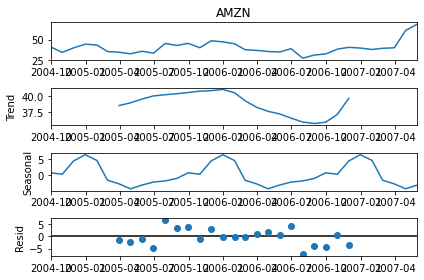

GOOG 



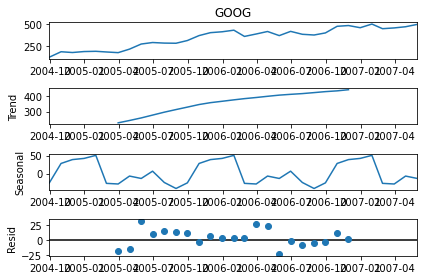

IBM 



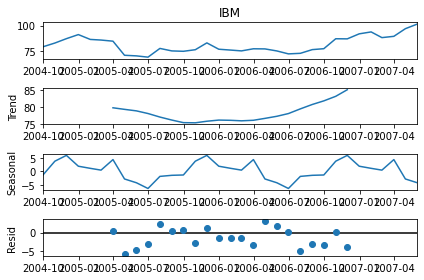

MSFT 



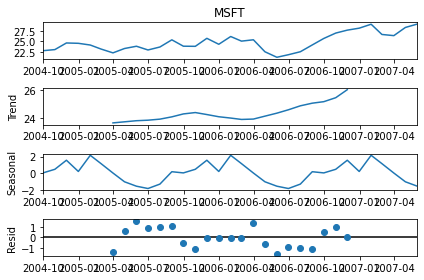

In [74]:
for col in train.columns:
    print(col,'\n') # new line
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

# Basic Holt's Linear Trend
**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

Holt:

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit:

- smoothing_level (α): value between (0,1)
- smoothing_slope (β): value between (0,1)

In [75]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized = True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items,2)

In [76]:
yhat_df.head()

,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2007-06-01,124.07,69.1,497.16,101.54,29.27
2007-07-01,126.94,69.1,502.81,101.54,29.45
2007-08-01,129.79,69.1,508.25,101.54,29.62
2007-09-01,132.63,69.1,513.51,101.54,29.80
2007-10-01,135.45,69.1,518.59,101.54,29.97


AAPL -- RMSE: 44


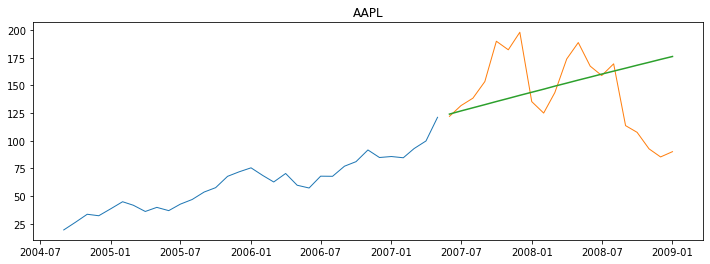

AMZN -- RMSE: 14


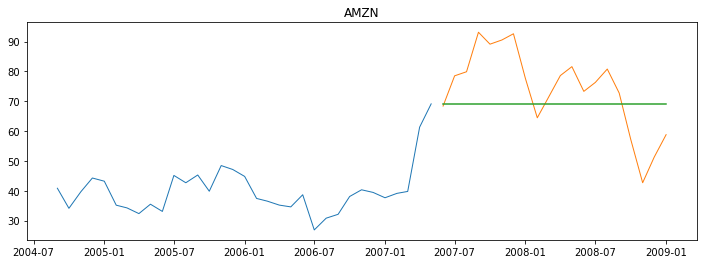

GOOG -- RMSE: 142


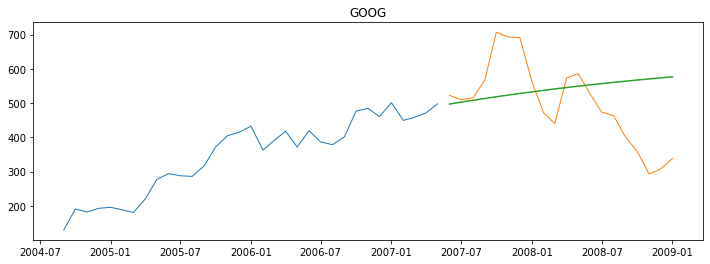

IBM -- RMSE: 13


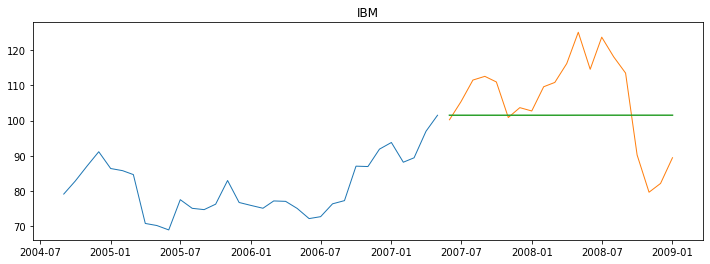

MSFT -- RMSE: 7


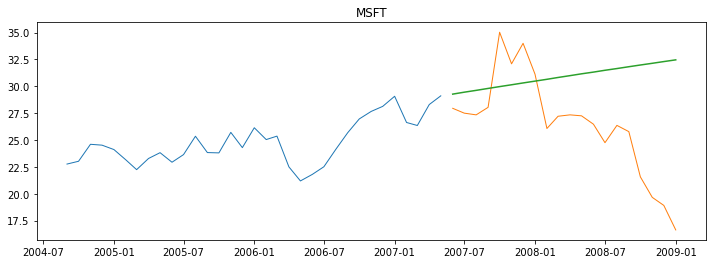

In [78]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [79]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized',
                            target_var = col)

In [80]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
9,simple_average,MSFT,5.0
14,Quarterly moving average,MSFT,5.0
4,last_observed_value,MSFT,5.0
19,holts_optimized,MSFT,7.0
18,holts_optimized,IBM,13.0
3,last_observed_value,IBM,13.0
1,last_observed_value,AMZN,14.0
16,holts_optimized,AMZN,14.0
13,Quarterly moving average,IBM,16.0
11,Quarterly moving average,AMZN,22.0


# Another model changing some hyperparameters¶

In [89]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(optimized = False, smoothing_level = .1, 
                      smoothing_slope = .1)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items,2)

AAPL -- RMSE: 46


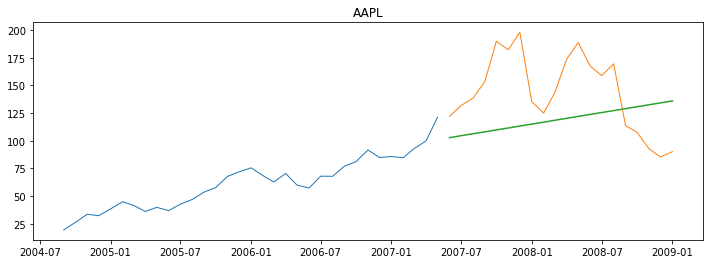

AMZN -- RMSE: 28


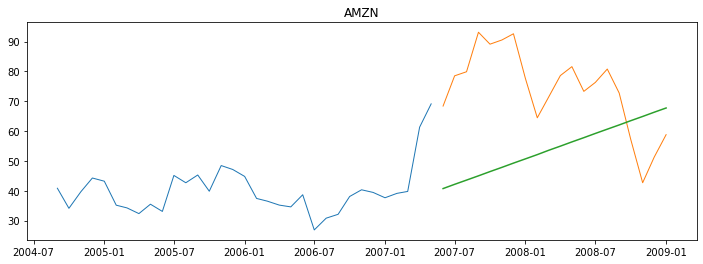

GOOG -- RMSE: 145


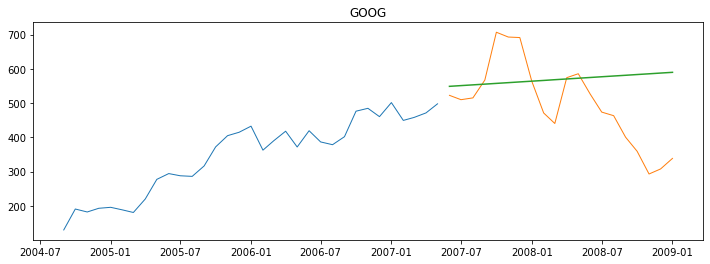

IBM -- RMSE: 21


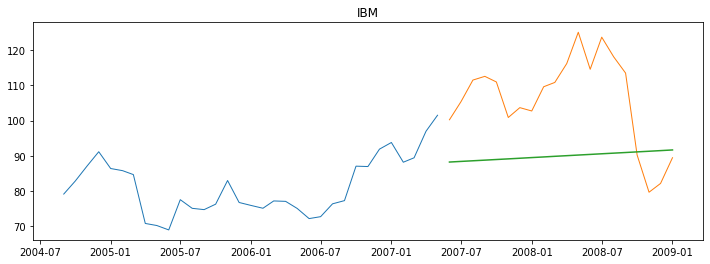

MSFT -- RMSE: 6


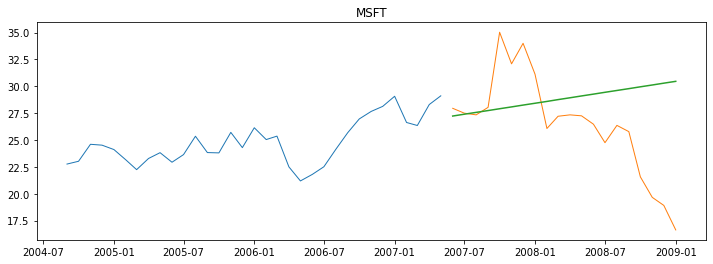

In [90]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [92]:
train.shape

(33, 5)

In [93]:
from vega_datasets import data
df = data('movies')

In [94]:
df.head()

,Title,US Gross,Worldwide Gross,US DVD Sales,Production Budget,Release Date,MPAA Rating,Running Time min,Distributor,Source,Major Genre,Creative Type,Director,Rotten Tomatoes Rating,IMDB Rating,IMDB Votes
0,The Land Girls,146083.0,146083.0,NaN,8000000.0,Jun 12 1998,R,NaN,Gramercy,None,None,None,None,NaN,6.1,1071.0
1,"First Love, Last Rites",10876.0,10876.0,NaN,300000.0,Aug 07 1998,R,NaN,Strand,None,Drama,None,None,NaN,6.9,207.0
2,I Married a Strange Person,203134.0,203134.0,NaN,250000.0,Aug 28 1998,None,NaN,Lionsgate,None,Comedy,None,None,NaN,6.8,865.0
3,Let's Talk About Sex,373615.0,373615.0,NaN,300000.0,Sep 11 1998,None,NaN,Fine Line,None,Comedy,None,None,13.0,NaN,NaN
4,Slam,1009819.0,1087521.0,NaN,1000000.0,Oct 09 1998,R,NaN,Trimark,Original Screenplay,Drama,Contemporary Fiction,None,62.0,3.4,165.0


In [95]:
df.isnull().sum()

Title                        1
US Gross                     7
Worldwide Gross              7
US DVD Sales              2637
Production Budget            1
Release Date                 0
MPAA Rating                605
Running Time min          1992
Distributor                232
Source                     365
Major Genre                275
Creative Type              446
Director                  1331
Rotten Tomatoes Rating     880
IMDB Rating                213
IMDB Votes                 213
dtype: int64

In [96]:
df.shape

(3201, 16)

In [ ]:
df = df.rename(columns = {'US Gross': 'us_gross', ''})

In [ ]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.Release Date)).\
        sort_values('ds').\
        assign(dollars_sold = df.sale_amount * df.item_price).\
        assign(items_sold = df.sale_amount).\
        groupby(['ds'])[['dollars_sold', 'items_sold']].sum().\
        reset_index().set_index('ds')